## Predicting Gross Square Footage
Our housing dataset contains a lot of missing values for gross square feet so we want to try to impute the missing values, rather than throwing our this feature or 40% of our data. 

Models tested: Linear Regression, Decision Tree Regressor, Random Forest Regressor

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn import metrics

## Data Import and Manipulation
When you ask your computer to import data, you must specify from where this data should be taken. This is generally done (for data at our scale) through explicit pointing to a file. Your computer does not understand what you mean if you simply ask it for a certain file, so you must point it directly to this data. This is done using a filepath. If you know where your data is, simply type that location, otherwise dragging and dropping into terminal will generally show you the filepath which you can then place in the fp variable.

In [2]:
fp = 'data/cleaned_allyears.csv' #Filepath: '/root/Folder/file.extension' 
data = pd.read_csv(fp) #Import data using filepath

/Users/Nicole/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7,8,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# list all of the columns we have in our dataset
data.columns

Index(['ADDRESS', 'BLOCK', 'BOROUGH', 'BUILDING CLASS AT PRESENT',
       'BUILDING CLASS AT TIME OF SALE', 'BUILDING CLASS CATEGORY',
       'COMMERCIAL UNITS', 'GROSS SQUARE FEET', 'LAND SQUARE FEET', 'LOT',
       'NEIGHBORHOOD', 'RESIDENTIAL UNITS', 'SALE DATE', 'SALE PRICE',
       'TAX CLASS AT PRESENT', 'TAX CLASS AT TIME OF SALE', 'TOTAL UNITS',
       'YEAR BUILT', 'ZIP CODE', '30 Year Rate', '15 Year Rate', 'AGE'],
      dtype='object')

In [4]:
data.shape

(166968, 22)

There are 166,968 properties in this data set with sale dates ranging from September 2016 to December 2018. 

In [5]:
# let's take a look at the data
data.head()

,ADDRESS,BLOCK,BOROUGH,BUILDING CLASS AT PRESENT,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,COMMERCIAL UNITS,GROSS SQUARE FEET,LAND SQUARE FEET,LOT,...,SALE DATE,SALE PRICE,TAX CLASS AT PRESENT,TAX CLASS AT TIME OF SALE,TOTAL UNITS,YEAR BUILT,ZIP CODE,30 Year Rate,15 Year Rate,AGE
0,153 AVENUE B,392,1,C2,C2,07 RENTALS - WALKUP APARTMENTS,0.0,6440,1633,6,...,7/19/17,6625000,2A,2,5.0,1900.0,10009.0,4.03,3.29,117.0
1,234 EAST 4TH STREET,399,1,C7,C7,07 RENTALS - WALKUP APARTMENTS,3.0,18690,4616,26,...,12/14/16,-,2,2,31.0,1900.0,10009.0,4.13,3.36,116.0
2,197 EAST 3RD STREET,399,1,C7,C7,07 RENTALS - WALKUP APARTMENTS,1.0,7803,2212,39,...,12/9/16,-,2,2,17.0,1900.0,10009.0,4.13,3.36,116.0
3,154 EAST 7TH STREET,402,1,C4,C4,07 RENTALS - WALKUP APARTMENTS,0.0,6794,2272,21,...,9/23/16,3936272,2B,2,10.0,1913.0,10009.0,3.48,2.76,103.0
4,301 EAST 10TH STREET,404,1,C2,C2,07 RENTALS - WALKUP APARTMENTS,0.0,4615,2369,55,...,11/17/16,8000000,2A,2,6.0,1900.0,10009.0,3.94,3.14,116.0


## Formatting data into appropriate value type
The dataset contains characters and numbers meant to represent missing values that need to be converted as such. Some categorical values are also hard to understand, for they are represented as numbers. These issues will all be fixed accordingly.

In [6]:
# convert missing values into NaN 
data['LAND SQUARE FEET'].replace(to_replace=' -  ',value=np.nan,inplace=True)
data['GROSS SQUARE FEET'].replace(to_replace=' -  ',value=np.nan,inplace=True)
data['SALE PRICE'].replace(to_replace=' -  ',value=np.nan,inplace=True)

# Cast string values into numeric values
data['SALE PRICE'] = pd.to_numeric(data['SALE PRICE'])
data['LAND SQUARE FEET'] = pd.to_numeric(data['LAND SQUARE FEET'])
data['GROSS SQUARE FEET'] = pd.to_numeric(data['GROSS SQUARE FEET'])
data['TOTAL UNITS'] = pd.to_numeric(data['TOTAL UNITS'])

# make sure total units is the sum of residential and commercial units
data['TOTAL UNITS'] = data['COMMERCIAL UNITS'] + data['RESIDENTIAL UNITS']

# Convert 0 into NaN in columns where 0 is impossible/doesn't make sense
data['SALE PRICE'].replace(to_replace=0,value=np.nan,inplace=True)
data['LAND SQUARE FEET'].replace(to_replace=0,value=np.nan,inplace=True)
data['GROSS SQUARE FEET'].replace(to_replace=0,value=np.nan,inplace=True)
data['TOTAL UNITS'].replace(to_replace=0,value=np.nan,inplace=True)

# Clarify categorical values
data['BOROUGH'].replace(to_replace = [1,2,3,4,5], value = ['Manhattan','Bronx','Brooklyn','Queens','Staten Island'],inplace=True)
data['TAX CLASS AT TIME OF SALE'].replace(to_replace = [1,2,4], value = ['House','Condo','Not_Res'],inplace=True)



In [7]:
# number of missing values
data.isnull().sum()

ADDRESS                               0
BLOCK                                 0
BOROUGH                               0
BUILDING CLASS AT PRESENT            49
BUILDING CLASS AT TIME OF SALE        0
BUILDING CLASS CATEGORY               0
COMMERCIAL UNITS                     49
GROSS SQUARE FEET                 58900
LAND SQUARE FEET                  63913
LOT                                   0
NEIGHBORHOOD                          0
RESIDENTIAL UNITS                    49
SALE DATE                             0
SALE PRICE                        49741
TAX CLASS AT PRESENT                 49
TAX CLASS AT TIME OF SALE             0
TOTAL UNITS                       40796
YEAR BUILT                            1
ZIP CODE                              1
30 Year Rate                          0
15 Year Rate                          0
AGE                               13267
dtype: int64

### Dealing with missing values
1. Drop features that we do not want to consider
2. For features with relatively few missing values, we will remove the instances that have missing values
3. For gross and land square feet, we will leave and attempt to impute them using various model techniques later on.

In [8]:
# Drop these columns because we dont want to introduce data that is post sale, 
# for we should only know information up to the sale data, or there could be potential data leakage
data.drop(labels='BUILDING CLASS AT PRESENT', inplace=True, axis=1)
data.drop('TAX CLASS AT PRESENT', inplace=True, axis=1)

In [9]:
data.isnull().sum()

ADDRESS                               0
BLOCK                                 0
BOROUGH                               0
BUILDING CLASS AT TIME OF SALE        0
BUILDING CLASS CATEGORY               0
COMMERCIAL UNITS                     49
GROSS SQUARE FEET                 58900
LAND SQUARE FEET                  63913
LOT                                   0
NEIGHBORHOOD                          0
RESIDENTIAL UNITS                    49
SALE DATE                             0
SALE PRICE                        49741
TAX CLASS AT TIME OF SALE             0
TOTAL UNITS                       40796
YEAR BUILT                            1
ZIP CODE                              1
30 Year Rate                          0
15 Year Rate                          0
AGE                               13267
dtype: int64

## Creating new informative features
It would be helpful to coarsen sale date to a yearly and monthly level to observe time trends

In [10]:
# convert sale date feature to date time format, create year and month categorial features
data['SALE_DATE'] = pd.to_datetime(data['SALE DATE'])
data['Year'] = data.SALE_DATE.dt.year.astype(str)
data['Month'] = data.SALE_DATE.dt.month.astype(str)

In [17]:
# ONLY keep rows with sales price greater than 100,000
model_data = data[data['SALE PRICE'] > 100000] 

In [18]:
# drop all rows with 1 more more Nan
model_data.dropna(axis=0,how='any',inplace=True)

/Users/Nicole/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
# Check the values in sale price
model_data.head()

,ADDRESS,BLOCK,BOROUGH,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,COMMERCIAL UNITS,GROSS SQUARE FEET,LAND SQUARE FEET,LOT,NEIGHBORHOOD,...,TAX CLASS AT TIME OF SALE,TOTAL UNITS,YEAR BUILT,ZIP CODE,30 Year Rate,15 Year Rate,AGE,SALE_DATE,Year,Month
0,153 AVENUE B,392,Manhattan,C2,07 RENTALS - WALKUP APARTMENTS,0.0,6440.0,1633.0,6,ALPHABET CITY,...,Condo,5.0,1900.0,10009.0,4.03,3.29,117.0,2017-07-19,2017,7
3,154 EAST 7TH STREET,402,Manhattan,C4,07 RENTALS - WALKUP APARTMENTS,0.0,6794.0,2272.0,21,ALPHABET CITY,...,Condo,10.0,1913.0,10009.0,3.48,2.76,103.0,2016-09-23,2016,9
4,301 EAST 10TH STREET,404,Manhattan,C2,07 RENTALS - WALKUP APARTMENTS,0.0,4615.0,2369.0,55,ALPHABET CITY,...,Condo,6.0,1900.0,10009.0,3.94,3.14,116.0,2016-11-17,2016,11
6,210 AVENUE B,406,Manhattan,C4,07 RENTALS - WALKUP APARTMENTS,0.0,4226.0,1750.0,32,ALPHABET CITY,...,Condo,8.0,1920.0,10009.0,3.48,2.76,96.0,2016-09-23,2016,9
9,629 EAST 5TH STREET,387,Manhattan,D9,08 RENTALS - ELEVATOR APARTMENTS,0.0,18523.0,4489.0,153,ALPHABET CITY,...,Condo,24.0,1920.0,10009.0,3.54,2.84,96.0,2016-11-07,2016,11


In [20]:
# reset index before spliting
model_data.reset_index(inplace=True)

## Set the features to be included in the model and response variable

In [21]:
columns = ['BOROUGH','BLOCK','LOT','RESIDENTIAL UNITS','COMMERCIAL UNITS',
           'AGE','TAX CLASS AT TIME OF SALE',
           '15 Year Rate','30 Year Rate','Year'] # 'BUILDING CLASS CATEGORY','TOTAL UNITS'
features = model_data.loc[:,columns] 
response = model_data.loc[:,'LAND SQUARE FEET'] 

In [19]:
# separate categorical features into dummy variables
features = pd.get_dummies(features)

# scale features to be on the same scale
ss = StandardScaler()
scaled_features = pd.DataFrame(ss.fit_transform(features.iloc[:,:7]),
                              columns=features.iloc[:,:7].columns).join(features.iloc[:,7:])

/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Holdout Set
When you do methods like cross-validation, since your entire dataset is playing a hand in establishing which of the hyperparameter tunings is optimal, you must worry about something called information leakage where information from the test set in your cross validation leaks into the model as you repeatedly check both. In simple terms, since you are training and testing on all your data, you need to set some aside that your model has never seen to get an unbiased estimate of the performance.

In [20]:
test_percent = 0.20 #Decide on test size
X, X_ho, y, y_ho = train_test_split(scaled_features, response, test_size=test_percent) #Create holdout data

## Establish Hyperparameter Ranges
When you are tuning a model - that is changing things that are necessarily declared explicitly as the data does not drive them, you must decide on the set of values that you wish to test. Note that the relationship between the time the model will take and the number of variables in the model is exponential as you add more parameters. In other words, be aware that the more values you include in your search for the optimal model, the longer the program will take.

Time to complete fitting takes the value:
$$Computation\ Time= \left(\prod_{k=1}^{n} \mid P_k \mid \right) \times CV\ Folds,\ n\ parameters,\ \mid\ \mid\ denotes\ magnitude$$

The GridSearchCV takes a dictionary of lists where the key is the name of the parameter being tuned and the body is the values on which to test it. The method will then check every possible combination of these values.

## Linear Regression Model

In [24]:
lm = LinearRegression()
lm.fit(X,y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [25]:
lm.score(X,y)

0.23543924269927896

## Decision Tree Model

In [26]:
dtree = DecisionTreeRegressor(criterion='mse') 
dtree.fit(X,y)

grid = {'min_samples_leaf':[10,20,30,40,50], 
        'max_depth':[5,10,15,20,25,30]} 
cross_val_folds = 3 #This is how many k-folds the cross validation will perform

gscv_tree = GridSearchCV(dtree,grid,cv=cross_val_folds,verbose=True,
                    return_train_score=False) #Create GridSearchCV Object

gscv_tree.fit(X,y) #This fit method will check all of your possible combinations

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   14.7s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_leaf': [10, 20, 30, 40, 50], 'max_depth': [5, 10, 15, 20, 25, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=True)

## Evaluating GridSearchCV Results
What this method does is test all the possible combinations of hyperparameters and remember what happened with each iteration so you can make an informed decision on which model has the best performance for your use. You can access things like the amount of time it took to fit each model, each accuracy, the best model, the best score, and so on. 

In [27]:
all_results = gscv_tree.cv_results_ #All Results Columns
best_model = gscv_tree.best_estimator_ #Returns an object of your model fit with the best performing parameters
best_score = gscv_tree.best_score_ #Returns best cross validation score of the models checked
best_hp = gscv_tree.best_params_ #Returns the parameters of the best model

print('The best model had parameters:',best_hp)
print('This gave a ',str(cross_val_folds),' fold CV score of:',best_score)
print('The holdout performance on this model is:',best_model.score(X_ho,y_ho))

The best model had parameters: {'max_depth': 25, 'min_samples_leaf': 10}
This gave a  3  fold CV score of: 0.37452170439888066
The holdout performance on this model is: 0.546134017339338


# Random Forest Model

In [28]:
rf = RandomForestRegressor() 
rf.fit(X,y)
grid = {'n_estimators':[10,20,30,40,50], 
        'max_depth':[1,2,3,4,5,10,15,20],
        #'min_samples_leaf':[50,100,200]
       } 
cross_val_folds = 3

gscv_rf = GridSearchCV(rf,grid,cv=cross_val_folds,verbose=True,
                    return_train_score=False) 
gscv_rf.fit(X,y) #This fit method will check all of your possible combinations

/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  3.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 20, 30, 40, 50], 'max_depth': [1, 2, 3, 4, 5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=True)

## Evaluating GridSearchCV Results
What this method does is test all the possible combinations of hyperparameters and remember what happened with each iteration so you can make an informed decision on which model has the best performance for your use. You can access things like the amount of time it took to fit each model, each accuracy, the best model, the best score, and so on.

In [29]:
all_results = gscv_rf.cv_results_ #All Results Columns
best_model = gscv_rf.best_estimator_ #Returns an object of your model fit with the best performing parameters
best_score = gscv_rf.best_score_ #Returns best cross validation score of the models checked
best_hp = gscv_rf.best_params_ #Returns the parameters of the best model

print('The best model had parameters:',best_hp)
print('This gave a ',str(cross_val_folds),' fold CV score of:',best_score)
print('The holdout performance on this model is:',best_model.score(X_ho,y_ho))

The best model had parameters: {'max_depth': 15, 'n_estimators': 20}
This gave a  3  fold CV score of: 0.6226073000082432
The holdout performance on this model is: 0.7115523255970582


## Choosing a Model
It's important to note that this will only give us the absolute best performance without regard for complexity. In other words, even if you supply a parameter for complexity control, the `best_score_` attribute will only return the absolute best performance on the cross validation. Because of this, we may have models that are extremely complicated, but when compared to a simple model fail to add any significant predictive ability. We can counter this by analyzing our results and choosing the best performing and simplest model. The give and take of complexity to performance is very much a product of experience and feeling where you make a cut off at the point you feel that you are losing too much accuracy to continue to simplify. This will create a dataframe that should allow you to compare all of your models and select the one you believe is best.

In [30]:
# one method of getting desired scores 
all_scores = pd.DataFrame(gscv_rf.cv_results_)[['params','mean_test_score'
                                          ]].sort_values('mean_test_score',
                                                         ascending=False).reset_index()
max_depth_values = all_scores.params.get('max_depth',default=1)

In [31]:
# one method of getting desired scores 
all_scores = pd.DataFrame(gscv_rf.cv_results_).filter(regex='params+|mean_test_score'
                                            ).sort_values('mean_test_score',
                                                          ascending=False).reset_index().drop(['index'],axis=1)
all_scores

,mean_test_score,params
0,0.622607,"{'max_depth': 15, 'n_estimators': 20}"
1,0.601586,"{'max_depth': 15, 'n_estimators': 50}"
2,0.598914,"{'max_depth': 20, 'n_estimators': 30}"
3,0.597842,"{'max_depth': 20, 'n_estimators': 10}"
4,0.597781,"{'max_depth': 20, 'n_estimators': 20}"
5,0.595631,"{'max_depth': 10, 'n_estimators': 20}"
6,0.589533,"{'max_depth': 15, 'n_estimators': 30}"
7,0.584660,"{'max_depth': 20, 'n_estimators': 50}"
8,0.582949,"{'max_depth': 15, 'n_estimators': 40}"
9,0.578224,"{'max_depth': 20, 'n_estimators': 40}"


## Final Performance Evaluation
Now that you have selected the model that you think gives the best performance, make sure there are no violations of assumptions since we are working with regression. Check for:
- Multicollinearity: remove columns that has a high multicollinaerity value (research what is considered a large value)
- Predicted vs. residuals: there should be no visible pattern. If there is, autocorelation is present and regression is invalid (will discuss how to deal with this if it is a problem)
- check the p-values or feature_importance: understand the significance of each feature

After performing checks and removing what's necessary, redo Gridsearch to get final model

In [21]:
# our best performing model
rf = RandomForestRegressor(max_depth=15,n_estimators=20) 
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [22]:
rf_imp = list(zip(features.columns,rf.feature_importances_))
rf_feat = pd.DataFrame(rf_imp,columns=['Feature','Importance'],index=None)

In [24]:
rf_feat.sort_values(by='Importance',ascending=False)

,Feature,Importance
2,RESIDENTIAL UNITS,0.221126
0,BLOCK,0.182847
1,LOT,0.161363
11,BOROUGH_Staten Island,0.144003
3,COMMERCIAL UNITS,0.095231
4,AGE,0.066526
6,30 Year Rate,0.032939
10,BOROUGH_Queens,0.022865
5,15 Year Rate,0.016253
16,Year_2017,0.014554


In [102]:
pd.Series([VIF(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

/Users/Nicole/anaconda3/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


BLOCK                                  1.534024
LOT                                    1.607812
RESIDENTIAL UNITS                      1.053948
COMMERCIAL UNITS                       1.045480
AGE                                    1.371922
15 Year Rate                         654.830346
30 Year Rate                         361.199538
BOROUGH_Bronx                               inf
BOROUGH_Brooklyn                            inf
BOROUGH_Manhattan                           inf
BOROUGH_Queens                              inf
BOROUGH_Staten Island                       inf
TAX CLASS AT TIME OF SALE_Condo             inf
TAX CLASS AT TIME OF SALE_House             inf
TAX CLASS AT TIME OF SALE_Not_Res           inf
Year_2016                                   inf
Year_2017                                   inf
Year_2018                                   inf
Year_2019                                   inf
dtype: float64

/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Nicole/anaconda3/lib/python3.6/si

/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Nicole/anaconda3/lib/python3.6/si

/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Nicole/anaconda3/lib/python3.6/si

/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Nicole/anaconda3/lib/python3.6/si

/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Nicole/anaconda3/lib/python3.6/si

[Text(0,0.5,'R2'), Text(0.5,0,'Features')]

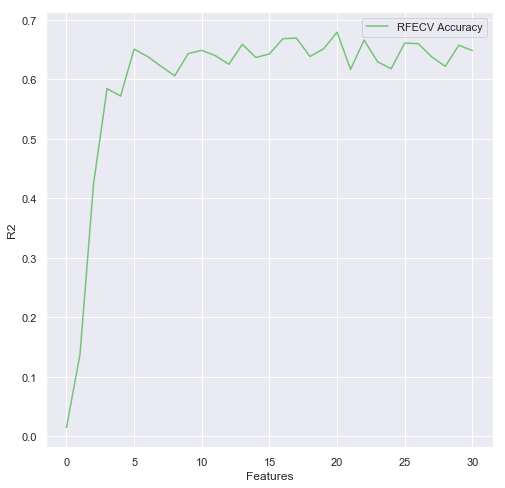

In [81]:
# recursive feature elimination with cross validated selection of best number of features
rfecv = RFECV(RandomForestRegressor(max_depth=20),cv=5,scoring='r2')
rfecv.fit(X,y)
plt.figure(figsize=(8,8))
sns.lineplot(data=pd.DataFrame({'RFECV Accuracy':rfecv.grid_scores_ }),palette='Greens').set(
    xlabel='Features',ylabel='R2')

# Final Model Evaluation
You will need to check one final time the holdout accuracy. After doing this, visualize the accuracy via a confusion matrix, AUC, etc. Reference the sklearn documentation for your model to see which accuracy evaluation tool they used.

In [149]:
final_model = RandomForestRegressor(max_depth=15,n_estimators=20)
final_model.fit(X,y)
print('Model Achieves Holdout Accuracy Of:',final_model.score(X_ho,y_ho)) #Score new fitted model


Model Achieves Holdout Accuracy Of: 0.7255878444595045


## Save Imputed Data
Now that we have predicted Gross Square Feet, we want to impute our predicted values. We will add these imputed values onto the imputed dataset from the Land Square Footage Model.

In [153]:
data = pd.read_csv('imputed_data.csv')  # from the Land Square Footage Model

In [155]:
data.reset_index(inplace=True,drop=True)
data.rename(columns={'Prediction':'LAND SQFT Prediction'},inplace=True)

In [156]:
# copy dataset to create feature data to be passed into our trained model
clean_data = data[['Sale_ID','BOROUGH','BLOCK','LOT','RESIDENTIAL UNITS','COMMERCIAL UNITS',
           'AGE','TAX CLASS AT TIME OF SALE',
           '15 Year Rate','30 Year Rate','Year']]
clean_data['Year'] = clean_data.Year.astype(str)
clean_data.dropna(axis=0,how='any',inplace=True)

In [160]:
clean_data.reset_index(inplace=True,drop=True)
clean_data.tail()

,Sale_ID,BOROUGH,BLOCK,LOT,RESIDENTIAL UNITS,COMMERCIAL UNITS,AGE,TAX CLASS AT TIME OF SALE,15 Year Rate,30 Year Rate,Year
153648,166962,Staten Island,7349,12,2.0,0.0,20.0,House,4.24,4.81,2018
153649,166963,Staten Island,7094,61,0.0,0.0,0.0,House,4.15,4.66,2018
153650,166964,Staten Island,7267,289,1.0,0.0,0.0,House,4.15,4.71,2018
153651,166965,Staten Island,7267,298,1.0,0.0,0.0,House,4.00,4.52,2018
153652,166966,Staten Island,7267,299,1.0,0.0,0.0,House,4.08,4.60,2018


In [161]:
columns = ['BOROUGH','BLOCK','LOT','RESIDENTIAL UNITS','COMMERCIAL UNITS',
           'AGE','TAX CLASS AT TIME OF SALE',
           '15 Year Rate','30 Year Rate','Year'] 
features_2 = clean_data.loc[:,columns] #Select all columns that are not the response

In [162]:
features_2.shape

(153653, 10)

In [163]:
# convert categorical features into dummy variables and scale the features
features_2 = pd.get_dummies(features_2)

ss = StandardScaler()
scaled_features_2 = pd.DataFrame(ss.fit_transform(features_2.iloc[:,:7]),
                              columns=features_2.iloc[:,:7].columns).join(features_2.iloc[:,7:])

/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [164]:
scaled_features_2.isnull().sum()

BLOCK                                0
LOT                                  0
RESIDENTIAL UNITS                    0
COMMERCIAL UNITS                     0
AGE                                  0
15 Year Rate                         0
30 Year Rate                         0
BOROUGH_Bronx                        0
BOROUGH_Brooklyn                     0
BOROUGH_Manhattan                    0
BOROUGH_Queens                       0
BOROUGH_Staten Island                0
TAX CLASS AT TIME OF SALE_Condo      0
TAX CLASS AT TIME OF SALE_House      0
TAX CLASS AT TIME OF SALE_Not_Res    0
Year_2016                            0
Year_2017                            0
Year_2018                            0
Year_2019                            0
dtype: int64

In [165]:
# Predicted value of gross square feet
clean_data['Gross Sqft Prediction'] = (final_model.predict(scaled_features_2))

/Users/Nicole/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [166]:
clean_data.head(50)

,Sale_ID,BOROUGH,BLOCK,LOT,RESIDENTIAL UNITS,COMMERCIAL UNITS,AGE,TAX CLASS AT TIME OF SALE,15 Year Rate,30 Year Rate,Year,Gross Sqft Prediction
0,0,Manhattan,392,6,5.0,0.0,117.0,Condo,3.29,4.03,2017,2185.928276
1,1,Manhattan,399,26,28.0,3.0,116.0,Condo,3.36,4.13,2016,4947.826393
2,2,Manhattan,399,39,16.0,1.0,116.0,Condo,3.36,4.13,2016,3058.921619
3,3,Manhattan,402,21,10.0,0.0,103.0,Condo,2.76,3.48,2016,2324.847488
4,4,Manhattan,404,55,6.0,0.0,116.0,Condo,3.14,3.94,2016,2185.928276
5,5,Manhattan,405,16,20.0,0.0,117.0,Condo,3.23,3.96,2017,3115.349933
6,6,Manhattan,406,32,8.0,0.0,96.0,Condo,2.76,3.48,2016,2252.958296
7,7,Manhattan,407,18,44.0,2.0,117.0,Condo,3.23,3.96,2017,8069.992824
8,8,Manhattan,379,34,15.0,0.0,97.0,Condo,3.18,3.91,2017,2786.584017
9,9,Manhattan,387,153,24.0,0.0,96.0,Condo,2.84,3.54,2016,4351.752047


In [168]:
# merge predictions onto original dataset
imputed_data = data.merge(clean_data[['Sale_ID','Gross Sqft Prediction']],
                          on='Sale_ID',how='left')

In [170]:
# general summary stats of our new imputed data
imputed_data.describe()

,Unnamed: 0,Sale_ID,Sale_ID_x,BLOCK,COMMERCIAL UNITS,GROSS SQUARE FEET,LAND SQUARE FEET,LOT,RESIDENTIAL UNITS,SALE PRICE,...,YEAR BUILT,ZIP CODE,30 Year Rate,15 Year Rate,AGE,Year,Month,Sale_ID_y,LAND SQFT Prediction,Gross Sqft Prediction
count,166968.000000,166968.00000,166968.00000,166968.00000,166919.000000,1.080680e+05,1.030550e+05,166968.000000,166919.000000,1.172270e+05,...,166967.000000,166967.000000,166968.000000,166968.000000,153701.000000,166968.000000,166968.000000,153653.000000,1.536530e+05,1.536530e+05
mean,82952.552333,83483.50000,83483.50000,4316.10711,0.211228,4.328538e+03,6.780808e+03,367.034959,1.980470,1.586716e+06,...,1795.046321,10766.770278,4.252220,3.605771,67.377050,2017.352828,6.556658,84328.125640,6.108812e+03,5.067606e+03
std,47367.704813,48199.65421,48199.65421,3603.22454,7.191613,3.172145e+04,3.911247e+04,656.777332,16.002497,1.410004e+07,...,528.384499,1144.762737,0.388887,0.466751,34.261609,0.808270,3.413710,48183.604849,2.430052e+04,2.141548e+04
min,0.000000,0.00000,0.00000,1.00000,0.000000,1.000000e+00,1.000000e+00,1.000000,0.000000,1.000000e+00,...,0.000000,0.000000,3.420000,2.720000,-1.000000,2016.000000,1.000000,0.000000,1.533620e+03,1.811746e+03
25%,41741.750000,41741.75000,41741.75000,1336.00000,0.000000,1.264000e+03,2.000000e+03,22.000000,0.000000,3.860000e+05,...,1920.000000,10306.000000,3.970000,3.230000,47.000000,2017.000000,4.000000,42817.000000,2.470732e+03,2.482259e+03
50%,83483.500000,83483.50000,83483.50000,3378.00000,0.000000,1.815000e+03,2.525000e+03,50.000000,1.000000,6.440000e+05,...,1940.000000,11209.000000,4.300000,3.550000,73.000000,2017.000000,6.000000,83760.000000,3.330754e+03,2.984720e+03
75%,125225.250000,125225.25000,125225.25000,6410.00000,0.000000,2.680000e+03,4.000000e+03,450.000000,2.000000,1.075178e+06,...,1965.000000,11357.000000,4.550000,4.020000,93.000000,2018.000000,10.000000,126379.000000,4.716501e+03,3.902533e+03
max,153652.000000,166967.00000,166967.00000,16350.00000,2261.000000,3.750565e+06,4.252327e+06,9106.000000,2229.000000,2.397502e+09,...,2019.000000,11697.000000,4.940000,4.360000,906.000000,2019.000000,12.000000,166966.000000,3.260849e+06,3.233577e+06


In [171]:
# drop excess columns
imputed_data.drop(columns=['Unnamed: 0','Sale_ID_x','Sale_ID_y'],inplace=True)

In [174]:
# save fully imputed dataset
imputed_data.to_csv('data/full_imputed_data.csv',index=False)